# Exploratory Data Analysis
## Analysis of Restaurants in Tucson City Arizona for Recommendation System Project

















### 3. Executive Summary

This project develops a recommendation system model tailored to restaurants in Tucson, Arizona, using Yelp dataset. By analyzing user reviews, ratings, and interactions specific to the Tucson restaurant category, the system identifies patterns and similarities between users and dining establishments to predict and suggest relevant restaurants. Leveraging the Yelp Open Dataset, the solution focuses on localized user behavior and preferences, employing machine learning NLP techniques such as BERT, TF-IDF sentiment analysis, VADER etc to deliver accurate and personalized recommendations. This system aims to enhance the dining experience for Yelp users in Tucson by helping them discover new restaurants aligned with their tastes, while also driving engagement and satisfaction for the platform.


### Skills Gained
- Problem Solving & Critical Thinking
- Explaratory Data Analysis
- Data cleaning and Visualization
- Sentiment Analysis using VADER, NLT, SpaCy, BERT TF-IDF
- Recommendater systems

### 4. Data Sources

For this project, I are using the Yelp Open Dataset, focusing on key JSON files to build a hybrid recommendation system for restaurants in Tucson, Arizona. The primary datasets include:

1. **Reviews Dataset (review.json)**  
   - Contains user-generated reviews and ratings for restaurants.  
   - Key fields include user_id, business_id, stars (ratings), and text (review content)  
   - **Purpose**: Forms the core of the CF model by providing user-item interactions (ratings). The review text can also be used for sentiment analysis to refine recommendations.

2. **Business Dataset (business.json)**  
   - Provides detailed business information, including categories and location.  
   - Key fields include business_id, name, categories, city, and state.  
   - **Purpose**: Filters the dataset to include only restaurants in Tucson, AZ, and provides metadata (e.g., restaurant names and categories) for interpretable recommendations.

3. **User Dataset (user.json)**  
   - Contains user profile data and rating behavior.  
   - Key fields include user_id, review_count, average_stars, and friends.  
   - **Purpose**: Enhances User-Based CF by identifying similar users based on review behavior and preferences. It also helps normalize ratings to account for individual rating biases.

These datasets collectively enable the creation of a robust and personalized restaurant recommendation system for Tucson based restaurants.

In [1]:
# Import necessary libraries
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install  boto3==1.28.57 botocore==1.31.57

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

import pandas as pd
import json

# Define file path
data_path = "/content/drive/MyDrive/yelp_dataset_proj/"
business_file = "/content/drive/MyDrive/yelp_dataset_proj/yelp_academic_dataset_business.json"

# Read business data in streaming mode (to avoid memory issues)
business_data = []

with open(business_file, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            business = json.loads(line)
            # Keep only restaurants in Tucson
            if business.get('city', '').lower() == 'tucson' and 'Restaurants' in str(business.get('categories', '')):
                business_data.append({
                    "business_id": business["business_id"],
                    "name": business["name"],
                    "categories": business.get("categories", ""),
                    "stars": business["stars"],
                    "review_count": business["review_count"],
                    "city": business["city"],
                    "state": business["state"],
                    "latitude": business["latitude"],
                    "longitude": business["longitude"]
                })
        except json.JSONDecodeError:
            print("Skipping malformed line.")

# Convert to DataFrame
business_df = pd.DataFrame(business_data)

# Save filtered business data for faster access later
business_df.to_csv(data_path + "filtered_business.csv", index=False)

print(f"Filtered Restaurants in Tucson: {business_df.shape[0]}")
print(business_df.head())
print(business_df.shape)

Filtered Restaurants in Tucson: 2469
              business_id                     name  \
0  wghnIlMb_i5U46HMBGx9ig  China Dragon Restaurant   
1  x9K0RfZaT_zlw6DklBDzjw  Gavi Italian Restaurant   
2  anLQj9AM8vjbcLSIE0iUgg            Papa Murphy's   
3  9C2rpb56aQvW0ViZHK9sPw    Home Plate Sports Pub   
4  Y6heWJJ9AmEL58fZwgi9YQ           Rosati's Pizza   

                                          categories  stars  review_count  \
0                               Restaurants, Chinese    3.0            23   
1                               Italian, Restaurants    3.5             9   
2                                 Pizza, Restaurants    4.0            22   
3          Bars, Restaurants, Sports Bars, Nightlife    3.5            56   
4  Sports Bars, Bars, Nightlife, Italian, Restaur...    4.0            58   

     city state   latitude   longitude  
0  Tucson    AZ  32.132305 -110.999985  
1  Tucson    AZ  32.221667 -110.925833  
2  Tucson    AZ  32.338572 -111.010760  
3  Tucson  

In [5]:
business_df.head()

business_id                     name  \
0  wghnIlMb_i5U46HMBGx9ig  China Dragon Restaurant   
1  x9K0RfZaT_zlw6DklBDzjw  Gavi Italian Restaurant   
2  anLQj9AM8vjbcLSIE0iUgg            Papa Murphy's   
3  9C2rpb56aQvW0ViZHK9sPw    Home Plate Sports Pub   
4  Y6heWJJ9AmEL58fZwgi9YQ           Rosati's Pizza   

                                          categories  stars  review_count  \
0                               Restaurants, Chinese    3.0            23   
1                               Italian, Restaurants    3.5             9   
2                                 Pizza, Restaurants    4.0            22   
3          Bars, Restaurants, Sports Bars, Nightlife    3.5            56   
4  Sports Bars, Bars, Nightlife, Italian, Restaur...    4.0            58   

     city state   latitude   longitude  
0  Tucson    AZ  32.132305 -110.999985  
1  Tucson    AZ  32.221667 -110.925833  
2  Tucson    AZ  32.338572 -111.010760  
3  Tucson    AZ  32.206315 -110.887843  
4  Tucson    AZ  32.338724 -111.030310

In [6]:
# Read data in streaming reviews for Tucson restaurants reviews
data_path = "/content/drive/MyDrive/yelp_dataset_proj/"
review_file = "/content/drive/MyDrive/yelp_dataset_proj/yelp_academic_dataset_review.json"
review_data = []



valid_business_ids = set(business_df['business_id'])

with open(review_file, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            review = json.loads(line)
            if review['business_id'] in valid_business_ids:
                review_data.append({
                    "review_id": review["review_id"],
                    "user_id": review["user_id"],
                    "business_id": review["business_id"],
                    "stars": review["stars"],
                    "text": review["text"],
                    "date": review["date"]
                })
        except json.JSONDecodeError:
            print("Skipping malformed line.")


review_df = pd.DataFrame(review_data)

# Save filtered reviews
review_df.to_csv(data_path + "filtered_review.csv", index=False)

print(f"Filtered Reviews for Tucson Restaurants: {review_df.shape[0]}")

print(review_df.shape)

Filtered Reviews for Tucson Restaurants: 249813
(249813, 6)


In [7]:
print(review_df.head())

                review_id                 user_id             business_id  \
0  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
1  UBp0zWyH60Hmw6Fsasei7w  4Uh27DgGzsp6PqrH913giQ  otQS34_MymijPTdNBoBdCw   
2  ymhbOMW63B_vGaRFR3XT0A  yZdAhQ_KmKuCZmbBy9YDQg  5Ce3lZksYVkCbrihqylVHQ   
3  onlgwy5qGDEzddsrnIvtWg  pYXeL0RCqus2IfhthYCOyA  W7NxQw8UYFR0HLPrI08tvw   
4  ypFqmURIY41F4pWaMW1VrQ  hToW2eoTAYlOcuNz7I73Cg  7L1kXfwU5XM6f6Jxo_L7Yg   

   stars                                               text  \
0    3.0  Family diner. Had the buffet. Eclectic assortm...   
1    4.0  The bun makes the Sonoran Dog. It's like a snu...   
2    5.0  I just started going to Sushi Nara this month ...   
3    4.0  Don't know what it is but If my tummy's feelin...   
4    5.0  We've been coming here since I was a kid. The ...   

                  date  
0  2014-02-05 20:30:30  
1  2011-10-27 17:12:05  
2  2014-07-25 17:56:26  
3  2012-02-01 14:21:25  
4  2015-07-03 22:36:04  


In [8]:
user_file = "/content/drive/MyDrive/yelp_dataset_proj/yelp_academic_dataset_user.json"
data_path = "/content/drive/MyDrive/yelp_dataset_proj/"


user_data = []


valid_user_ids = set(review_df['user_id'])

with open(user_file, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            user = json.loads(line)
            if user['user_id'] in valid_user_ids:
                user_data.append({
                    "user_id": user["user_id"],
                    "name": user.get("name", ""),
                    "review_count": user["review_count"],
                    "average_stars": user["average_stars"]
                })
        except json.JSONDecodeError:
            print("Skipping malformed line.")

user_df = pd.DataFrame(user_data)


user_df.to_csv(data_path + "filtered_user.csv", index=False)

print(f"Filtered Users Who Reviewed Tucson Restaurants: {user_df.shape[0]}")
print(user_df.shape)

Filtered Users Who Reviewed Tucson Restaurants: 81380
(81380, 4)


### 5. Summary Statistics of the Data


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter
import seaborn as sns






In [10]:

# 1. Basic Summary Statistics
num_reviews = review_df.shape[0]
num_restaurants = business_df.shape[0]
num_users = user_df.shape[0]


print(f"Number of Reviews: {num_reviews}")
print(f"Number of restaurants: {num_restaurants}")
print(f"Number of Users: {num_users}")

Number of Reviews: 249813
Number of restaurants: 2469
Number of Users: 81380


In [11]:
import nltk


nltk.download('punkt_tab')

# 2. NLP-Specific Statistics
review_df['tokenized_text'] = review_df['text'].apply(nltk.word_tokenize)
total_tokens = sum(review_df['tokenized_text'].apply(len))
all_words = [word.lower() for tokens in review_df['tokenized_text'] for word in tokens]
unique_words = len(set(all_words))
avg_review_length = np.mean(review_df['tokenized_text'].apply(len))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [12]:
print(f"Total Number of Tokens: {total_tokens}")
print(f"Number of Unique Words (Vocabulary Size): {unique_words}")
print(f"Average Review Length (Words per Review): {avg_review_length}")

Total Number of Tokens: 28568696
Number of Unique Words (Vocabulary Size): 133515
Average Review Length (Words per Review): 114.36032552349157


In [13]:

# 3. Other Key Statistics
unique_customers = review_df['user_id'].nunique()
avg_stars_per_review = review_df['stars'].mean()
star_distribution = review_df['stars'].value_counts().sort_index()
business_review_counts = review_df['business_id'].value_counts()


print(f"Number of Unique Customers: {unique_customers}")
print(f"Average Stars per Review: {avg_stars_per_review}")
print("Star Distribution:")
print(star_distribution)




Number of Unique Customers: 81381
Average Stars per Review: 3.736006532886599
Star Distribution:
stars
1.0     33250
2.0     23092
3.0     28062
4.0     57362
5.0    108047
Name: count, dtype: int64


In [14]:
# Top 10 most reviewd restaurants
top_reviewed_restaurants = review_df['business_id'].value_counts().head(10)

# get restaurant names
top_restaurants = business_df[business_df['business_id'].isin(top_reviewed_restaurants.index)][['business_id', 'name']]

# Merge data
top_restaurants = top_restaurants.merge(top_reviewed_restaurants, left_on='business_id', right_index=True)

# Rename columns
top_restaurants.columns = ['business_id', 'business_name', 'review_count']

# Sort by review count
top_restaurants = top_restaurants.sort_values(by='review_count', ascending=False)

print(top_restaurants)

                 business_id                  business_name  review_count
36    UCMSWPqzXjd7QHq7v8PJjQ                  Prep & Pastry          2230
803   LZzDvgfpkd4nI3E4L9wF1w                 El Charro Cafe          1617
2301  zZ01WQlcpI1_n806WKV3bA               Culinary Dropout          1355
555   tV46IhCfHbsx_af-pMupiw                 Cafe Poca Cosa          1331
1316  muxda1cSVtplETqTfYVgZA  HUB Restaurant & Ice Creamery          1329
254   WSx9-iYYyST_umny9sJBFg                     The Parish          1253
1322  Rv8bW3pkzpi5dZu5ckbgtA     Guadalajara Original Grill          1153
822   hyeo7JQr5uLp-St1MibYAA                      Baja Cafe          1130
589   j8feOxyJqlIJWOi8su2qzw                Serial Grillers          1025
787   wj8XtPyuREj8_0GQz3LZ6w              Wild Garlic Grill          1025


In [15]:
# Reviews per restaurant
reviews_per_business = review_df['business_id'].value_counts()
avg_reviews_per_business = reviews_per_business.mean()

# Reviews per user
reviews_per_user = review_df['user_id'].value_counts()
avg_reviews_per_user = reviews_per_user.mean()

sample_size_stats = {
    "Average Reviews per Business": avg_reviews_per_business,
    "Average Reviews per User": avg_reviews_per_user
}

sample_size_df = pd.DataFrame.from_dict(sample_size_stats, orient='index', columns=['Value'])


from IPython.display import display
display(sample_size_df)

Value
Average Reviews per Business  101.179830
Average Reviews per User        3.069672

#### Distribution of Star Ratings

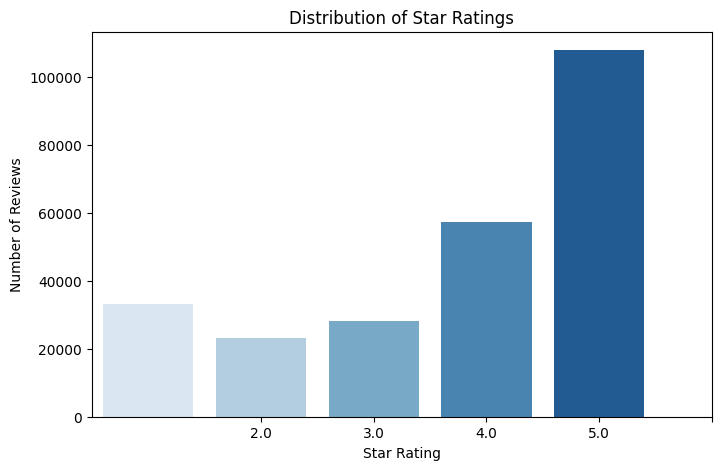

In [16]:


# 4. Visualizations
plt.figure(figsize=(8,5))
sns.barplot(x=star_distribution.index, y=star_distribution.values, palette="Blues")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Star Ratings")
plt.xticks([1,2,3,4,5])
plt.show()



	•	The majority of reviews are 5-star (108,047), followed by 4-star (57,362) reviews.
	•	1-star reviews (33,250) are relatively fewer, indicating that most customers leave positive ratings.

#### Distribution of Reviews per Restaurant

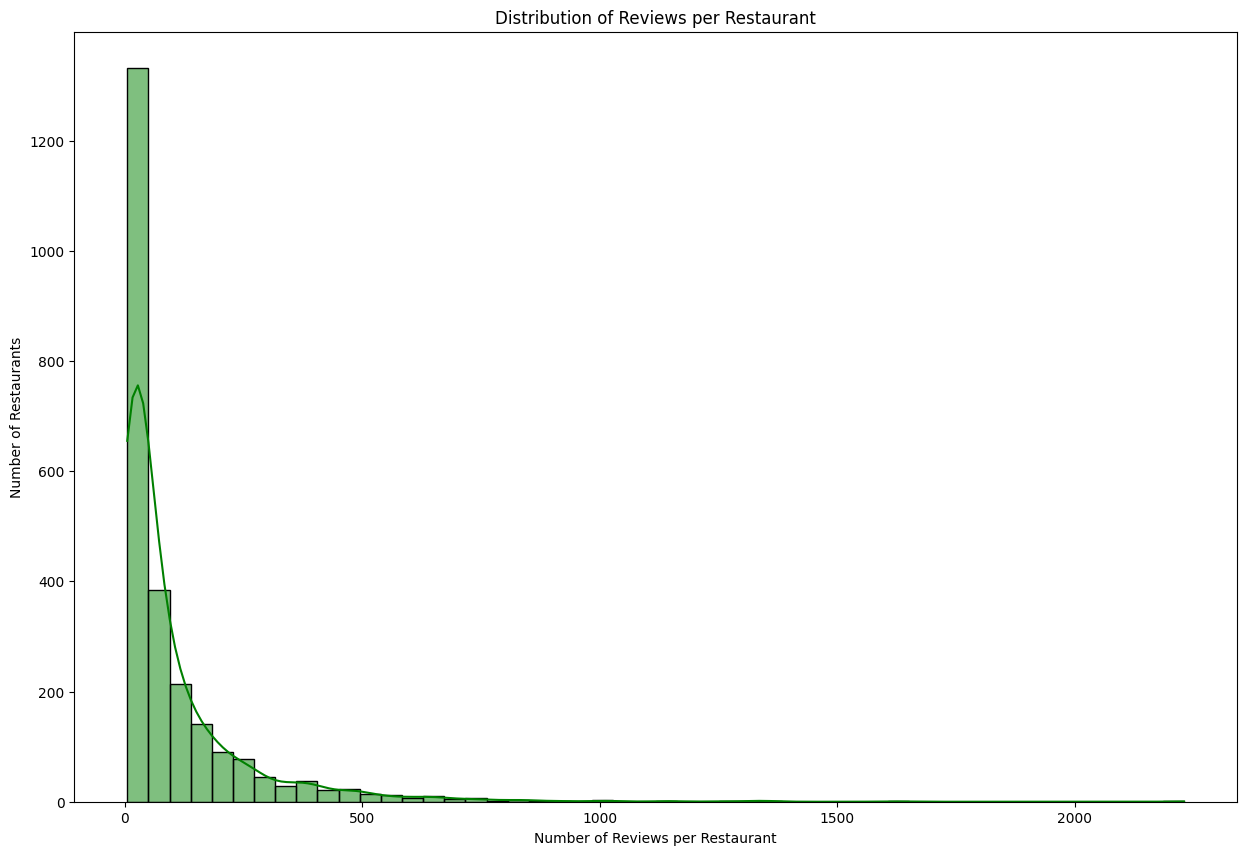

In [17]:
plt.figure(figsize=(15,10))
sns.histplot(business_review_counts, bins=50, kde=True, color='green')
plt.xlabel("Number of Reviews per Restaurant")
plt.ylabel("Number of Restaurants")
plt.title("Distribution of Reviews per Restaurant")
plt.show()



- A large number of restaurants have very few reviews, while a small fraction receives a high volume.
- This suggests that popular restaurants dominate reviews, which may introduce a bias in recommendations.

#### Distribution of Review Lengths

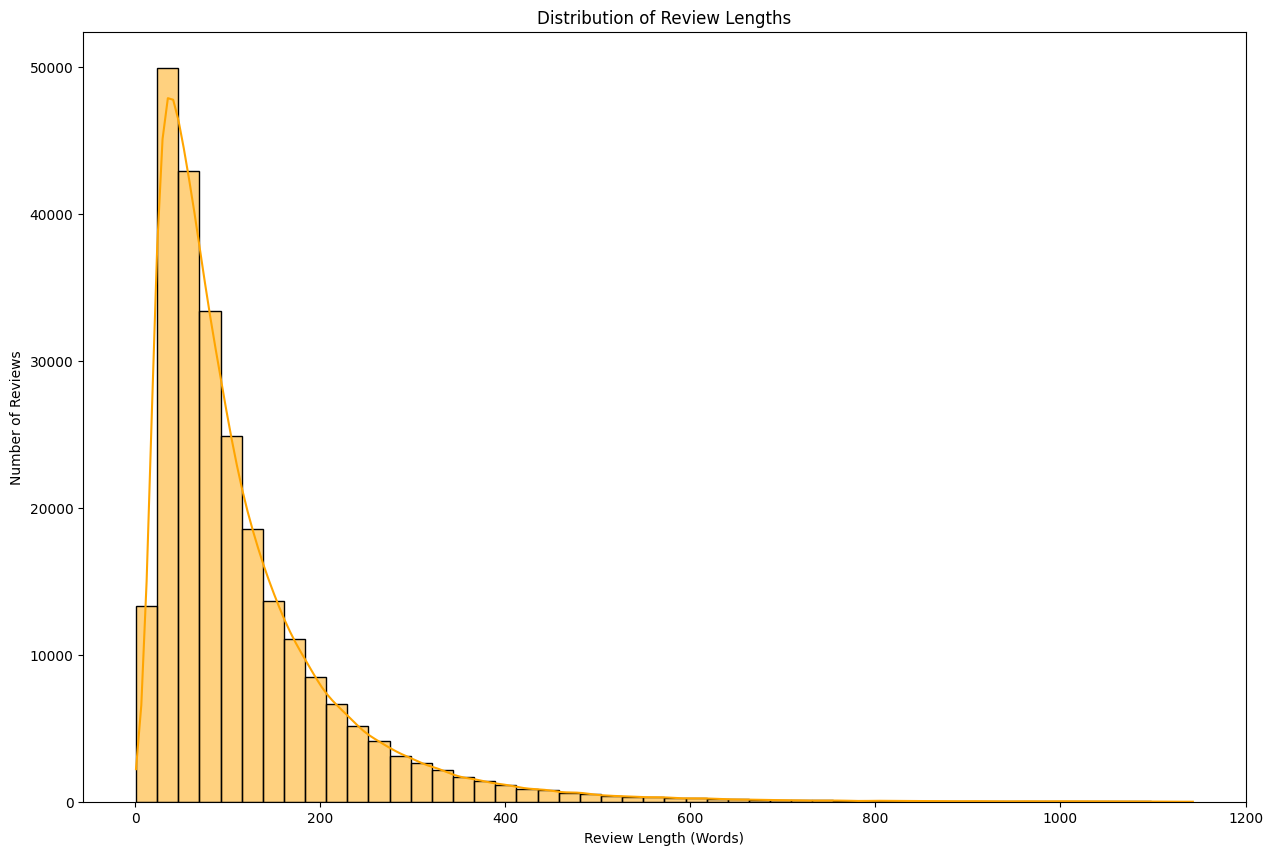

In [18]:
# Distribution of Review Lengths
review_lengths = review_df['tokenized_text'].apply(len)

plt.figure(figsize=(15,10))
sns.histplot(review_lengths, bins=50, kde=True, color='orange')
plt.xlabel("Review Length (Words)")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Lengths")
plt.show()


- Most reviews are short, peaking around 50-150 words, but some extend beyond 500 words.
- This indicates that users vary in how detailed their feedback is, which may impact NLP-based recommendations.

#### Most Frequent Words in Reviews


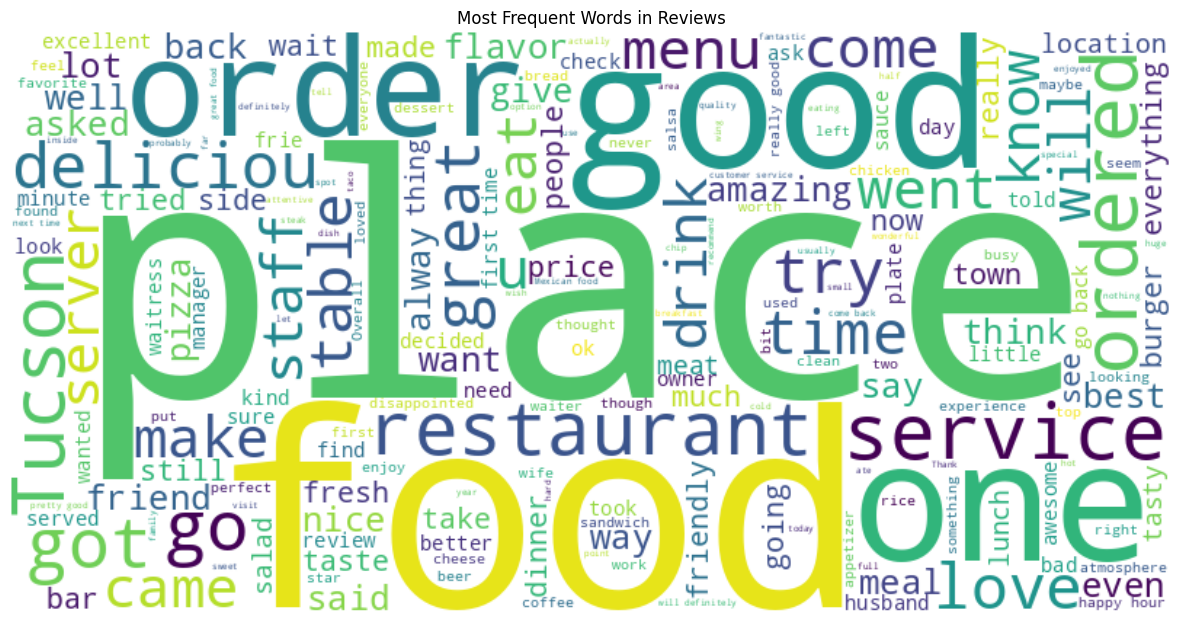

In [19]:
# Word cloud for most frequent words in reviews

from wordcloud import WordCloud


all_reviews = " ".join(review_df['text'])


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)


plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Reviews")
plt.show()

Words like “food,” “place,” “service,” and “order” are dominant, highlighting key themes in customer feedback.
This can be useful for sentiment analysis and context-aware recommendations.

 #### Average User Ratings

       average_stars
count   81380.000000
mean        3.678804
std         1.062087
min         1.000000
25%         3.100000
50%         3.880000
75%         4.450000
max         5.000000


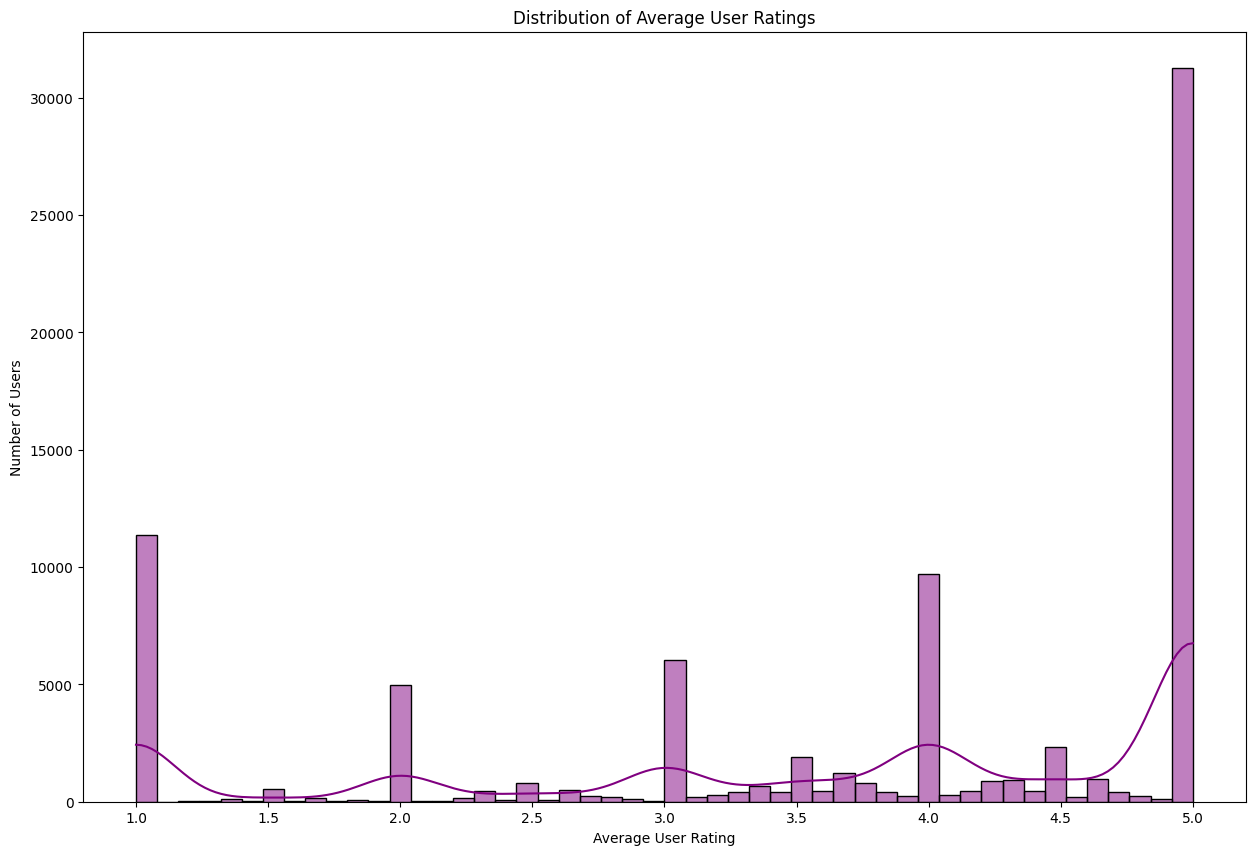

In [20]:
# Average User Ratings

user_avg_ratings = review_df.groupby('user_id')['stars'].mean()

# Merge with user_df to get user details
user_avg_ratings_df = user_df.merge(user_avg_ratings, on='user_id')

# summary statistics
print(user_avg_ratings_df[['name', 'average_stars']].describe())

# plot
plt.figure(figsize=(15,10))
sns.histplot(user_avg_ratings, bins=50, kde=True, color='purple')
plt.xlabel("Average User Rating")
plt.ylabel("Number of Users")
plt.title("Distribution of Average User Ratings")
plt.show()

	•	Users tend to cluster around extreme ratings (1-star and 5-star), suggesting polarized opinions.
	•	This may affect collaborative filtering algorithms, requiring adjustments for rating normalization.

##### User Loyalty

In [21]:
# User Loyalty: How Many Users Review the Same Restaurant More Than Once?

# Count repeated reviews
repeat_reviews = review_df.groupby(['user_id', 'business_id']).size().reset_index(name='review_count')

# Filter users who reviewed the same Restaurant more than once
loyal_users = repeat_reviews[repeat_reviews['review_count'] > 1]


print(f"Total Users Who Reviewed the Same Restaurant Multiple Times: {loyal_users['user_id'].nunique()}")

Total Users Who Reviewed the Same Restaurant Multiple Times: 4648


#### Trends in User Rating Behavior Over Time

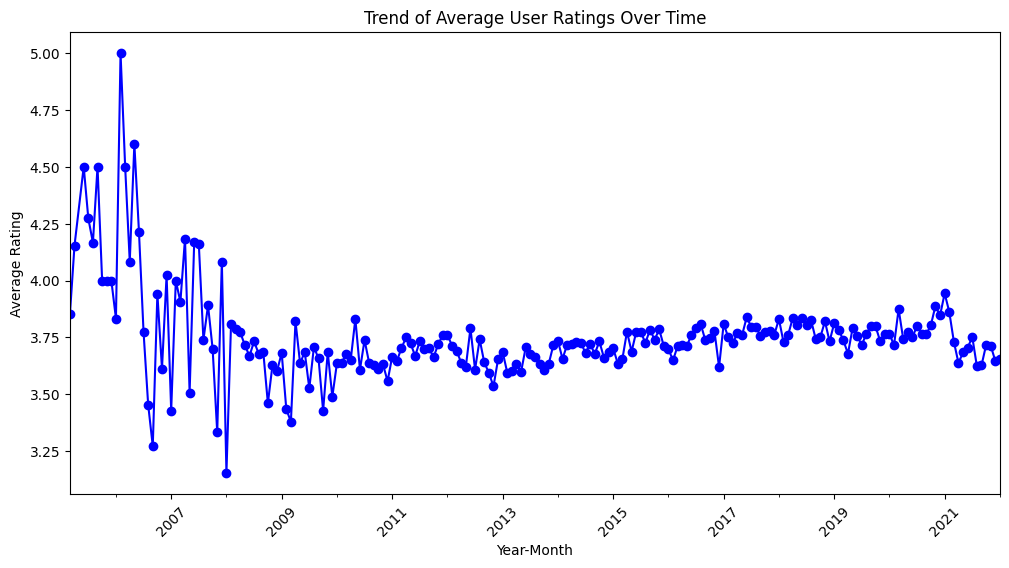

In [22]:
# Trends in User Rating Behavior Over Time

review_df['date'] = pd.to_datetime(review_df['date'])

# Aggregate ratings over time
ratings_over_time = review_df.groupby(review_df['date'].dt.to_period("M"))['stars'].mean()

# Plot trend
plt.figure(figsize=(12,6))
ratings_over_time.plot(kind='line', color='blue', marker='o')
plt.xlabel("Year-Month")
plt.ylabel("Average Rating")
plt.title("Trend of Average User Ratings Over Time")
plt.xticks(rotation=45)
plt.show()

	•	Ratings fluctuated significantly in earlier years but stabilized over time around 3.5 - 3.8 stars.
	•	This trend reflects shifts in user behavior or improvements in Restaurant services.

In [23]:
business_df.columns

Index(['business_id', 'name', 'categories', 'stars', 'review_count', 'city',
       'state', 'latitude', 'longitude'],
      dtype='object')

#### Plot the geographical distribution of restaurants in Tucson

In [24]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import display



if 'latitude' in business_df.columns and 'longitude' in business_df.columns:
    # Filter for restaurants in Tucson
    business_df = business_df[business_df['city'].str.lower() == "tucson"]

    # Create a Folium map centered on Tucson
    tucson_map = folium.Map(location=[business_df['latitude'].mean(), business_df['longitude'].mean()],
                            zoom_start=12, tiles="OpenStreetMap")

    #  clustered markers for restaurants
    marker_cluster = MarkerCluster().add_to(tucson_map)

    for _, row in business_df.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=row['name'],
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(marker_cluster)


    display(tucson_map)
else:
    print("Latitude and Longitude columns not found in business data.")


### 6. Data Evaluation

##### A. Why the Selected Data is Suitable for Our Business Questions

- We aim to build a Hibrid Recommendation System for Yelp restaurants in Tucson City, Arizona.
We believe the filtered dataset meets this objective because:
  - It contains explicit user-item interactions: Ratings and reviews provide rich user preference data.
  - NLP features enhance recommendations: Text reviews allow sentiment analysis and context-aware recommendations.
  - High engagement level: With 249,813 reviews from 81,380 users across 2,469 restaurants, we have enough data to generate meaningful recommendations.

This dataset is well-suited for both Collaborative Filtering (CF) and hybrid NLP-based recommendations.




####  B. Is the Sample Size Appropriate?
- Yes, the sample size is appropriate for building a recommendation system, with a total of 249,813 reviews, 2,469 restaurants and over 80k users
- Sufficient Reviews per Business : With 101+ reviews per business, there’s enough data to model restaurant popularity and customer preferences.
- Diverse Businesses : 2,469 restaurants provide varied options, which is beneficial for recommendation diversity.



####  C. Could the Selected Data Be Biased?

Potential biases in our dataset:
- High number of 5-star reviews (108,047 out of 249,813 total reviews). The system may over-recommend highly rated restaurants, ignoring neutral reviews.

- Reviewing behavior varies by user. Some users are frequent reviewers, while others leave only 1 or 2 reviews.

- Data is limited to Tucson restaurants. The recommendation model won’t generalize beyond this city.


In conclusion: Most ratings are 4 or 5 stars, which may introduce a positivity bias.	The system may need rating normalization to avoid bias toward higher-rated restaurants.


#### D. Potential Challenges in Data Processing

 1. Sparse Data Problem:
	Many users review only a few restaurants, making it harder for CF models to find user-item similarities.
	A solution is to use a hybrid model (CF + NLP features) to boost recommendations.

 2. No Explicit User Preferences Beyond Ratings: Ratings alone do not capture true preferences (e.g., a 3-star rating could be positive or neutral).
The work around on this is to extract sentiment from text reviews and integrate NLP embeddings in the CF model.

3. Cold Start Problem: New users and restaurants lack review history, making it difficult to recommend. There is need to use business metadata (category, location) for content-based filtering.

4. User behaviour is constaly shifting over time, which presents a challenge for recommendation systems to keep nimble and adapt to the dynamic customer review behabiours.

We hope to address some of these these challenges to improve recommendation quality and user experience.

### Preliminary Data Exploration


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


          Word  Frequency
0         food     189829
1         good     144632
2        place     127816
3        great     110612
4      service      94638
5         like      81642
6         time      75598
7          one      73936
8         back      71563
9          get      68005
10       would      66528
11          go      63370
12      really      60041
13     ordered      56357
14       order      54071
15  restaurant      52336
16      tucson      51676
17        also      51388
18          us      50824
19   delicious      47882


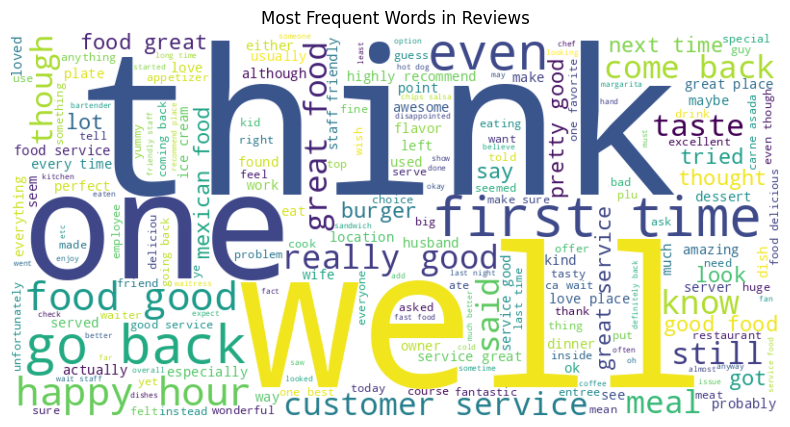

In [25]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Download
nltk.download('punkt')
nltk.download('stopwords')



# Tokenize reviews
review_df['tokenized_text'] = review_df['text'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
review_df['filtered_text'] = review_df['tokenized_text'].apply(lambda tokens: [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words])

# Flatten the list of words across all reviews
all_words = [word for tokens in review_df['filtered_text'] for word in tokens]

# Count word frequencies
word_freq = Counter(all_words)

# Top 20 most common words
top_words = word_freq.most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Display top words
print(top_words_df)

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Reviews")
plt.show()



#### Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


sentiment
positive    213616
negative     33122
neutral       3075
Name: count, dtype: int64


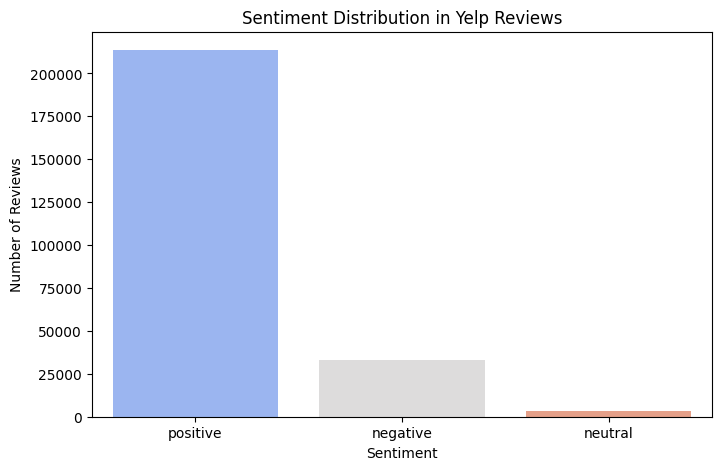

In [26]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# Download VADER if not available
nltk.download('vader_lexicon')


# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER to get sentiment scores
review_df['sentiment_score'] = review_df['text'].apply(lambda text: sia.polarity_scores(str(text))['compound'])

# Categorize Sentiment
review_df['sentiment'] = review_df['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

# Display Sentiment Distribution
sentiment_counts = review_df['sentiment'].value_counts()
print(sentiment_counts)

# Plot Sentiment Distribution
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution in Yelp Reviews")
plt.show()

We chose VADER (Valence Aware Dictionary and sEntiment Reasoner) because its built for social media and short texts, making it a good choice for Yelp reviews- a form of social media reviews tailored for business.

#### Topic Modeling  (Latent Dirichlet Allocation - LDA)
Topic modeling, the goal is to identify hidden topics in reviews, so as to enable us classify reviews into themes (e.g food quality, service, ambience)

In [27]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Tokenization & Stopword Removal
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english') # Changed to a list instead of a set

# Vectorizing text data
vectorizer = CountVectorizer(stop_words=stop_words, max_features=5000)
doc_term_matrix = vectorizer.fit_transform(review_df['text'])

# Train LDA Model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Display Top Words in Each Topic
words = vectorizer.get_feature_names_out()
topics = {}
for i, topic in enumerate(lda.components_):
    topics[f"Topic {i+1}"] = [words[j] for j in topic.argsort()[-10:]]

# Convert to DataFrame for display
topics_df = pd.DataFrame(topics)
print(topics_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   Topic 1   Topic 2  Topic 3  Topic 4     Topic 5
0       go       got  minutes    fresh        nice
1  service  sandwich     back    place  definitely
2     best      food    would     also        time
3     love   ordered      get    sauce       place
4   always   chicken      one    salad   delicious
5   tucson    burger  service     food        back
6     good     fries     time     like        good
7    great    cheese    order  chicken     service
8    place      like       us     good        food
9     food      good     food    pizza       great


LDA topic modeling identified five key themes in Yelp reviews:

-  Customer Experience & Service Quality: Focus on service, satisfaction, and repeat visits.

- Specific Food Items & Orders: Mentions of sandwiches, burgers, and fries dominate.

- Wait Time & Order Process: Concerns about service efficiency and delays.

- Freshness & Ingredients: Emphasis on food quality, freshness, and taste.

- Overall Restaurant Recommendation: Positive feedback and repeat visit intentions.

 #### Named Entity Recognition (NER) Using spaCy
NER goal is to extract named entities such as food items, restaurants, locations, brands etc. This will help us understand frequently mentioned menu items or restuarent features.

In [28]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Extract Named Entities from a Sample of Reviews
sample_reviews = " ".join(review_df['text'][:500])  # Limit to first 500 reviews for efficiency
doc = nlp(sample_reviews)

# Extract entities
entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['ORG', 'GPE', 'FOOD', 'MONEY']]


entity_df = pd.DataFrame(entities, columns=['Entity', 'Type']).value_counts().reset_index()
entity_df.columns = ['Entity', 'Type', 'Count']
print(entity_df.head(20))

        Entity   Type  Count
0       Tucson    GPE    105
1         taco    ORG     11
2      Arizona    GPE      8
3           BK    ORG      7
4            7  MONEY      5
5          BBQ    ORG      5
6   California    GPE      5
7         Yelp    ORG      5
8          Nox    ORG      4
9            5  MONEY      4
10          AJ    ORG      3
11   Guacamole    ORG      3
12    Speedway    ORG      3
13       Bacon    ORG      3
14        Taco    ORG      3
15         YUM    ORG      3
16      Raijin    GPE      3
17     Maynard    GPE      3
18          10  MONEY      3
19  University    ORG      2


Food Themes: Popular mentions (Taco, BBQ) can refine food-based recommendations.

Pricing: Money-related terms suggest cost is a key factor in restaurant choices.

Local Influence: Strong Tucson and University mentions indicate a student-driven user base.

####  Keyword-Based Review Categorization
Categorize reviews based on specific themes (e.g., service, food, price).
this Helps identify which aspects influence customer ratings the most.

In [29]:
# Define keywords for different themes
theme_keywords = {
    "service": ["service", "staff", "waiter", "customer", "friendly"],
    "food": ["food", "taste", "delicious", "menu", "dish", "meal"],
    "price": ["price", "expensive", "cheap", "cost", "worth"]
}

# Count mentions of each theme
def count_theme_mentions(text, keywords):
    return sum(1 for word in word_tokenize(str(text).lower()) if word in keywords)

for theme, keywords in theme_keywords.items():
    review_df[f"{theme}_mentions"] = review_df['text'].apply(lambda x: count_theme_mentions(x, keywords))

# Aggregate theme mentions
theme_counts = review_df[[f"{theme}_mentions" for theme in theme_keywords.keys()]].sum()


print(theme_counts)

service_mentions    192550
food_mentions       337578
price_mentions       44861
dtype: int64


- Food preferences should be a major factor - Users care most about the quality and variety of food, so menu-based content filtering can improve suggestions.
- Service quality matters significantly - Restaurants with consistently negative service mentions should be penalized in recommendations.
- Pricing is an important but secondary factor - Including price segmentation in filtering may help budget-conscious users.

#### Bigram and Trigram Analysis (Phrase Detection)
Finds common two-word or three-word phrases so as to reveal frequent themes in customer reviews.

In [30]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Tokenize reviews
review_df['tokenized_text'] = review_df['text'].apply(nltk.word_tokenize)

# Detect Bigrams
bigrams = Phrases(review_df['tokenized_text'], min_count=5, threshold=10)
bigram_model = Phraser(bigrams)

# Detect Trigrams
trigrams = Phrases(bigram_model[review_df['tokenized_text']], threshold=10)
trigram_model = Phraser(trigrams)

# Example Output
sample_text = review_df['tokenized_text'].iloc[0]
bigram_text = bigram_model[sample_text]
trigram_text = trigram_model[bigram_text]

print("Original:", sample_text)
print("Bigrams:", bigram_text)
print("Trigrams:", trigram_text)

Original: ['Family', 'diner', '.', 'Had', 'the', 'buffet', '.', 'Eclectic', 'assortment', ':', 'a', 'large', 'chicken', 'leg', ',', 'fried', 'jalapeño', ',', 'tamale', ',', 'two', 'rolled', 'grape', 'leaves', ',', 'fresh', 'melon', '.', 'All', 'good', '.', 'Lots', 'of', 'Mexican', 'choices', 'there', '.', 'Also', 'has', 'a', 'menu', 'with', 'breakfast', 'served', 'all', 'day', 'long', '.', 'Friendly', ',', 'attentive', 'staff', '.', 'Good', 'place', 'for', 'a', 'casual', 'relaxed', 'meal', 'with', 'no', 'expectations', '.', 'Next', 'to', 'the', 'Clarion', 'Hotel', '.']
Bigrams: ['Family', 'diner', '.', 'Had', 'the', 'buffet', '.', 'Eclectic', 'assortment', ':', 'a', 'large', 'chicken', 'leg', ',', 'fried', 'jalapeño', ',', 'tamale', ',', 'two', 'rolled', 'grape_leaves', ',', 'fresh', 'melon', '.', 'All', 'good', '.', 'Lots', 'of', 'Mexican', 'choices', 'there', '.', 'Also', 'has', 'a', 'menu', 'with', 'breakfast', 'served', 'all', 'day', 'long', '.', 'Friendly', ',', 'attentive', 'staf

1. Food-Related Phrases Stand Out
	•	“fried jalapeño”, “chicken leg”, “grape leaves”, “fresh melon” - Specific dishes highlight customer preferences.
	•	Insight: This confirms that menu-based filtering could enhance recommendations.

2. Service and Atmosphere Mentions
	•	“Friendly, attentive staff”, “casual relaxed meal” - Suggests users value service and ambiance.
	•	Insight: Restaurants frequently described as “friendly” or “attentive” could be prioritized in user-based recommendations.

3. Location References & Contextual Mentions
	•	“Next to the Clarion Hotel” - Indicates how users describe restaurant locations.
	•	Insight: Nearby landmarks (e.g., hotels, tourist areas) could be useful metadata for location-based recommendations.

4. Common Review Structure
	•	Users often structure reviews into food description - service quality → ambiance.
	•	Insight: Understanding this pattern can help in theme extraction and ranking restaurants accordingly.

### Proposed Solution
We propose a Hybrid recommendation systems using Yelp Dta Data. This apporach integrates machine learning and unstructured data analytics to imoprove recommnendation qualitty.

1. **Collaborative Filtering (User-Item & Item-Item)**
To identify preferences based on past interactions, we propose to use these algorithms: Singular Value Decomposition (SVD), k-Nearest Neighbors (kNN), Alternating Least Squares (ALS).

We shall build a user-item matrix (rows: users, columns: restaurants restaurants, values:ratings) and apply Matrix Factorization (SVD,ALS) to learn hidden patterns as well as KNN for similarity based recommendations (classification)

2. **Content Based Filtering (NLP Features)**
We hope to leverage TF-IDF, Word2Vec, BERT embeddings to recommend restaurants based on review content
Our approach is to extract text features from reviews using TF-IDF and Word2Vec, use cosine similarity to find similar restaurants

This approach works well for new restaurants with no user interactions
but can't suggest diverse options outside a user’s history.

3. **Sentiment Analysis (VADER)**
Assigns a sentiment score to each review. This will help us modify recommendations based on positive/negative sentiment trends
Prevents recommending highly rated but negatively reviewed restaurants.

4. **Topic Modeling (LDA)**
to identify trending discussions points in reviews (e.g., “good service”, “long wait time”).
We'll use Latent Dirichlet Allocation (LDA) to discover hidden themes and recommend restaurants based on topic similarity.
This approach will help refine recommendations beyond just star ratings.

5. **Named Entity Recognition (NER)**
To extract relevant business features from reviews.
We'll use spaCy NER to identify mentions of food items, location, service quality.
This approach will enhance context-aware recommendations.

6. **Model evaluation and optimization**
Evalution metrics will include;
	- RMSE (Root Mean Square Error): Measures rating prediction accuracy.
	- Precision@K, Recall@K: Measures recommendation relevance.
	- Mean Average Precision (MAP): Evaluates ranking effectiveness.
Optimization/hyper parameter tuning will use GridsearchCV for KNN and SVD Hyper parameters.



**Conclusion**

Our project focuses on creating a recommendation system for Yelp restaurants in Tucson, Arizona, utilizing machine learning and NLP techniques to improve user experience. Key insights from data analysis include the dataset's sparsity, dominance of 5-star reviews, and the richness of review text. Challenges such as the cold start problem, data sparsity, and rating bias were identified. To address these, we propose a Hybrid Recommendation System combining Collaborative Filtering, Content-Based Filtering, and NLP-enhanced methods like sentiment analysis and topic modeling. This approach aims to deliver personalized, diverse, and sentiment-aware recommendations, enhancing restaurant discovery on Yelp.